The Dataset used for this project can be found at: 

https://www.kaggle.com/alexteboul/heart-disease-health-indicators-dataset

In this project I will be using the above dataset to train a model to predict if someone is at risk for heart disease. 

Additionally, I will be looking into some other aspects of the dataset. Namely, do we observe a difference between men and women for the risk of heart disease?

Is there a difference in risk between type 1 and type 2 diabetics, or are both equal? 

What is the largest risk factor in having heart disease? 

Do males and females have a different highest risk factor?

Which variable is least impactful in heart disease?

Regardless of how accurate our model is, what kind of accuracy do we have? Is it better or worse than just saying nobody is at risk.

First let's load the modules we will need and examine the data.

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
%matplotlib inline
from sklearn import tree
import pydotplus
import graphviz
from IPython.display import Image
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR

#### Start by fetching, examining and cleaning the data to ensure the entries exist (no nulls) and are proper (not filled with zeros or symbols to represent nulls)

In [3]:
# fetch data
raw_data = pd.read_csv('https://raw.githubusercontent.com/christianloring/Projects/main/project_dataset.csv')

In [4]:
# check to make sure it has been retreived properly
raw_data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
# Examine the data more closely, here we will check for nulls and improper entries
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [6]:
# no nulls, all entries have a value. now we check for if there are zeros and if the zeros make sense, since some datasets will use 0 to represent nulls
columns = raw_data.columns
cols = []
count = []
for column in columns:
  count_col = (raw_data[column] == 0).sum()
  count.append([column, count_col])
  if column != 'HeartDiseaseorAttack':
    cols.append(column)
count

[['HeartDiseaseorAttack', 229787],
 ['HighBP', 144851],
 ['HighChol', 146089],
 ['CholCheck', 9470],
 ['BMI', 0],
 ['Smoker', 141257],
 ['Stroke', 243388],
 ['Diabetes', 213703],
 ['PhysActivity', 61760],
 ['Fruits', 92782],
 ['Veggies', 47839],
 ['HvyAlcoholConsump', 239424],
 ['AnyHealthcare', 12417],
 ['NoDocbcCost', 232326],
 ['GenHlth', 0],
 ['MentHlth', 175680],
 ['PhysHlth', 160052],
 ['DiffWalk', 211005],
 ['Sex', 141974],
 ['Age', 0],
 ['Education', 0],
 ['Income', 0]]

Check if the zeros make sense. The follow variables are binary: 

HeartDiseaseorAttack, HighBP, HighChol, CholCheck, Smoker, Stroke, Diabetes, HvyAlcoholConsump, NoDocbcCost, Sex, Fruits, Veggies

The following have zeros in their scale naturally:

PhysActivity, MentHlth, DiffWalk, PhysHlth

Observing where the number of zeros is largest, we see it is for values that represent some sort of issue the average person will not experience, thus they make sense being high and do not represent null values.
For the non-health issue related ones, we observe a moderate amount of zeros, which makes sense considering most people do not live a perfectly healthy lifestyle.
We can conclude that the zeroes in this set should not be null values nor values that are filled as zero from missing.

#### Predicting if a person is at risk of heart disease

In [7]:
# The first question I look at is the ML question of trying to train a model to predict if a person is at risk of heart disease.

# let's look at the variables using the first method learned, OLS regression.
# set target variable and explanatory variables


Y = raw_data['HeartDiseaseorAttack']
X = raw_data[cols]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [8]:
results = sm.OLS(y_train, X_train).fit()
# Inspect the results
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     HeartDiseaseorAttack   R-squared (uncentered):                   0.228
Model:                              OLS   Adj. R-squared (uncentered):              0.228
Method:                   Least Squares   F-statistic:                              2849.
Date:                  Thu, 03 Feb 2022   Prob (F-statistic):                        0.00
Time:                          12:04:02   Log-Likelihood:                         -22275.
No. Observations:                202944   AIC:                                  4.459e+04
Df Residuals:                    202923   BIC:                                  4.481e+04
Df Model:                            21                                                  
Covariance Type:              nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [9]:
# As expected, the first method is rather rough and has a low R sq value
# Now we apply some of the other techniques we learned to get more accurate results.
# First we try with a decision tree, then random forest, next gradient boosting, and finally svm 
# We will use gridsearch to ensure that we are getting an optimized result from each technique.
# This ensures we do not either get lucky or unlucky when picking parameters, but are truly
# choosing the best method. 

from sklearn.model_selection import GridSearchCV
decision_tree = tree.DecisionTreeClassifier()
param_dict_tree = {
    "criterion":['gini', 'entropy'],
    "max_depth":[2,3,4],
    "min_samples_split":[2,3,4],
    "min_samples_leaf":[2,3,4]
}
grid = GridSearchCV(decision_tree,
                    param_dict_tree,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


0.9068363683287297

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
param_dict_rfc = {
    "criterion":['gini', 'entropy'],
    "max_depth":range(1,4),
    "min_samples_split":range(2,4),
    "min_samples_leaf":range(2,4)
}
grid_rfc = GridSearchCV(rfc,
                    param_dict_rfc,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 4),
                         'min_samples_leaf': range(2, 4),
                         'min_samples_split': range(2, 4)},
             verbose=1)

In [11]:
grid_rfc.best_score_

0.90557986443548

In [13]:
gbc = ensemble.GradientBoostingClassifier(learning_rate = 0.2, min_samples_split=6, max_depth=3)
gbc.fit(X_train, y_train)

#boosting models

#accuracy
gbc.score(X_test, y_test)
#precision
y_pred = gbc.predict(X_test)
precision_score(y_test,y_pred)
# Recall
recall_score(y_test,y_pred)

print(gbc.score(X_test, y_test), precision_score(y_test,y_pred), recall_score(y_test,y_pred))

0.9086841690318511 0.5509355509355509 0.11202705559078419


Unfortunately, I cannot run gradient boosting classifier with gridsearch as it is too computationally intensive. 

gbc = ensemble.GradientBoostingClassifier()
param_dict_gbc = {
    "loss":('deviance', 'exponential'),
    "learning_rate":range(1,4),
    "criterion":('friedman_mse', 'squared_error', 'mse', 'mae'),
    "min_samples_split":range(2,4),
    "min_samples_leaf":range(2,4),
    "max_depth":range(1,2)

}
grid_gbc = GridSearchCV(gbc,
                    param_dict_gbc,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

grid_gbc.fit(X_train, y_train)
grid_gbc.best_score_


SVM is similar, when run it takes over an hour even before applying the gridsearch which would multiple the amount of time it takes by likely over a factor of thirty. 
If I am able to use a more powerful system, the following can be ran to observe that SVM both takes a very long time and (at least in this case) does not produce results
that are worth the cost.
for a single instance:
SVM
from sklearn.svm import SVR
svr = SVR()

Y = raw_data['HeartDiseaseorAttack'].sample(frac=0.3, replace=True, random_state=1)
X = raw_data[cols].sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

to test using gridsearch:
svr = SVR()
svr_dict = {
    "kernel":('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    'degree': (2,3),
    'gamme':('scale', 'auto'),
    'epsilon':(0.1,0.2,0.3)
}

grid_svr = GridSearchCV(svr, 
                        svr_dict, 
                        cv=5, 
                        verbose=1, 
                        n_jobs=-1)

grid_svr.fit(X_train, y_train)
grid_svr.best_score

Since we tuned the parameters to be optimized where possible, we can say that we can achieve a best rate of .9086 using GradientBoostingClassifiers. 
This is genuinely surprising because I was not able to optimize that method due to the intense resources it takes; however, what this tells us
is that the model will only get better if we can apply gridsearch to optimize it.



Now we can begin investigating some of the other questions we have from the dataset.

#### Is there a difference between males and females in terms of risk of heart disease?

In [14]:
#This data is not continuous, so we will use a non-parametric test,
#specifically the man whitney u test
male = raw_data[raw_data['Sex'] == 0]
female = raw_data[raw_data['Sex'] == 1]
stats.mannwhitneyu(male['HeartDiseaseorAttack'], female['HeartDiseaseorAttack'])

MannwhitneyuResult(statistic=7527983631.0, pvalue=0.0)

#### Who between type 1 and type 2 diabetics are more at risk?

In [15]:
# First we should see if there is a difference (Are either more at risk?) or if both are equal. 
# Once again we have noncontinuous data. This time it isn't binary, but we are still just comparing between 2 values,
# as we are not looking at people w/o diabetes. I'll use the kruskal test to answer this question.
type_1 = raw_data[raw_data['Diabetes']==1]
type_2 = raw_data[raw_data['Diabetes']==2]

stats.kruskal(type_1['HeartDiseaseorAttack'], type_2['HeartDiseaseorAttack'])

KruskalResult(statistic=154.02258174686844, pvalue=2.289780626831842e-35)

#### What are the two most important factors in determining risk of heart disease?

#### What is the least influential factor within the list?

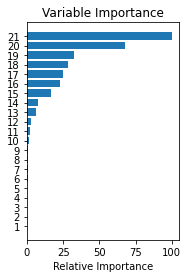

In [18]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) +1
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, )
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [19]:
print("The two most influential factors are " + X_train.columns[sorted_idx[0]],"and", X_train.columns[sorted_idx[1]])
print("The least influential factors is " + X_train.columns[sorted_idx[-1]]+".")

The two most influential factors are AnyHealthcare and PhysActivity
The least influential factors is GenHlth.


#### How good or bad is the model? Is it better than saying nobody is at risk?

In [20]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


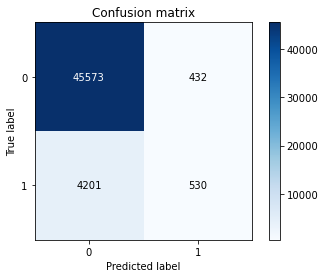

In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
import itertools
predict_test = gbc.predict(X_test)
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

This model is not very good. It is better than saying nobody is at risk, as that would be every value in the left hand column.

It will tell roughly 10% of the people at risk that they are at risk, which is also better than nothing; however, in terms of actual application I would not use this model. 

Perhaps if I had access to more powerful computations, I could have refined the gbc and svm models and we would have 